<a href="https://colab.research.google.com/github/magomeda228/Deep-Learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:19<00:00, 8.91MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


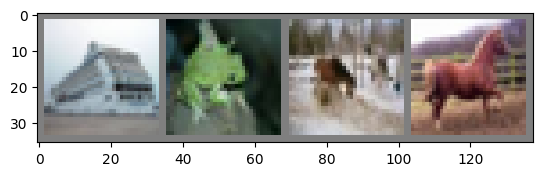

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

In [5]:
class BasicBlockNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bd1 = nn.BatchNorm2d(32)
        self.re = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bd2 = nn.BatchNorm2d(32)
        self.re2 = nn.ReLU(inplace=True)

        self.residual_transform = nn.Conv2d(3, 32, kernel_size=1, stride=1, bias=False)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, n_classes)

    def forward(self, x):
        identity = self.residual_transform(x)
        out = self.conv1(x)
        out = self.bd1(out)
        out = self.re(out)
        out = self.conv2(out)
        out = self.bd2(out)

        out += identity
        out = self.re(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)


        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bd1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (re): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bd2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (re2): ReLU(inplace=True)
  (residual_transform): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [8]:
from IPython.display import clear_output

In [9]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    loss_fn = nn.CrossEntropyLoss()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        loss_val = loss_fn(output, target)
        loss_log.append(loss_val.item())

        preds = torch.argmax(output,dim=1)
        acc = (preds == target).float().mean()
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    loss_fn = nn.CrossEntropyLoss()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        loss = loss_fn(output, target)
        loss_log.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(output,dim=1)
        acc = (preds == target).float().mean()
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    hist_train_loss, hist_train_acc, hist_val_loss, hist_val_acc = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        # Добавляем в списки все потери и точности
        train_loss_log.extend(train_loss)  # Добавляем все значения потерь на тренировке
        train_acc_log.extend(train_acc)  # Добавляем все значения точности на тренировке

        val_loss_log.append(val_loss)  # Добавляем потери на валидации
        val_acc_log.append(val_acc)  # Добавляем точность на валидации

        hist_train_loss.append(np.mean(train_loss))  # Среднее по потерям на тренировке
        hist_train_acc.append(np.mean(train_acc))  # Среднее по точности на тренировке
        hist_val_loss.append(val_loss)  # Потери на валидации
        hist_val_acc.append(val_acc)

        clear_output()
        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        #hist_train_loss, hist_train_acc, hist_val_loss, hist_val_acc = np.mean(train_loss), np.mean(train_acc), val_loss, val_acc
        if scheduler is not None:
            scheduler.step()

    return hist_train_loss, hist_train_acc, hist_val_loss, hist_val_acc


In [10]:
from IPython.display import clear_output
def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies, test_loss=0, test_acc=0):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    # Убедитесь, что передаются списки или массивы
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    if test_loss!=0:
      axs[0].axhline(y=test_loss, color='r', linestyle='--', label='train loss')
      axs[1].axhline(y=test_acc, color='r', linestyle='--', label='train acc')

    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].set_xlabel('epoch')


    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='val')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].set_xlabel('epoch')

    plt.show()

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)


Epoch 19
 train loss: 1.0790724918872827, train acc: 0.6226454361919075
 val loss: 1.169732502166261, val acc: 0.5812278369639782



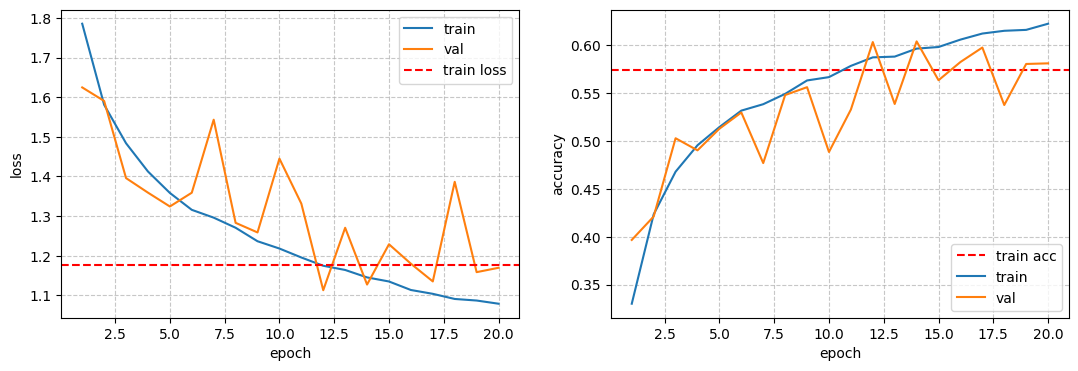

In [12]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log, test_loss_log, test_acc_log)

In [12]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 19
 train loss: 1.05373654799226, train acc: 0.6319739162595006
 val loss: 1.0479847228273433, val acc: 0.6305407803109352



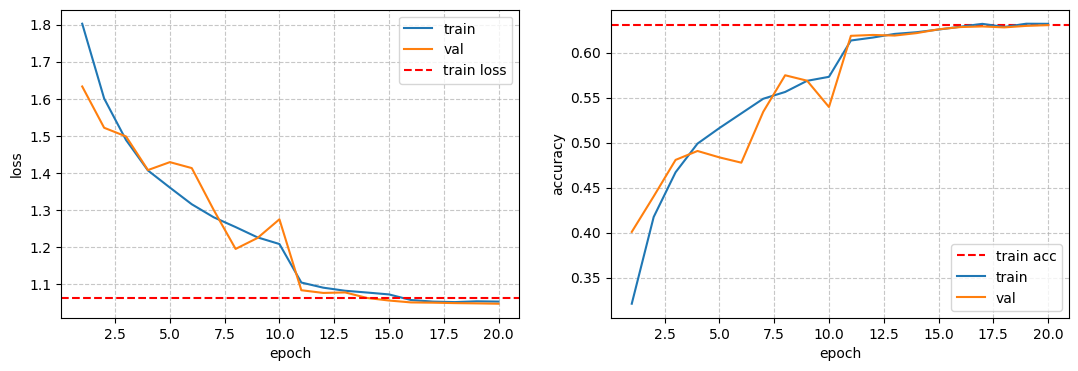

In [13]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log, test_loss_log, test_acc_log)

С добавкой планировщика изменения шага обучения, а именно MultiStepLR (ступенчатое понижение шага обучения) с гиперпараметром gamma=0.1 на эпохах от 10 до 15 мы имеем хорошо обученную модель с монотонным снижение значения функции потерь на валидации (с 1.6 до ~1.1) и на обучении ~0.9 на всех эпохах.

Также график accuracy хорошо себя проявляет на всех эпохах, как например: на валидации растет монотонно с 0.35 до 0.64, а на обучении колеблется около 0.7, примечательно что прямая характеризующая функцию потерь на тренировочной выборке, характеризует апроксимационную прямую к значению которой стремится кривая функции потерь на валидации, тоже самое касается и метрики accuracy

В свою очередь это говорит о правильности нашей модели.

In [14]:
import time

In [15]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
start = time.time()
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
end = time.time()
print(f"duration: {end-start}")

Epoch 19
 train loss: 1.4858524117216985, train acc: 0.47343056282569984
 val loss: 1.4460353338972052, val acc: 0.49155585106382976

duration: 319.7662281990051


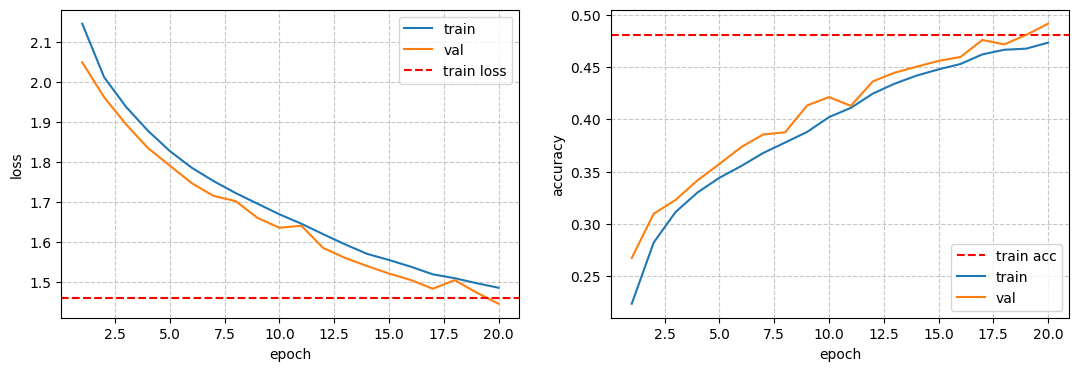

In [16]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log, test_loss_log, test_acc_log)

Сделав lr=0.001 видно что модель схожим образом обучается как и при планировщике обучения, но вместе с этим видно что итоговая метрика accuracy меньше по всех этапах работы модели, вместе с функией потерь.
accuracy на валидации и тесте 0.48, на обучении 0.7
в то время как с планировщиком обучения метрика accuracy на тесте и на обучении стремится к 0.63

Что однозначно подтверждает преимущество использования планировщика при обучении, чем постановки малой скорости обучения, как и время обучения, тоже подтверждает данный вывод (4 минуты против ~5)

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
start = time.time()
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
end = time.time()
print(f"duration: {end-start}")

Epoch 19
 train loss: 1.1020486655575266, train acc: 0.6110970554447697
 val loss: 1.1145703041807133, val acc: 0.6141843973322118

duration: 324.94867634773254


Сделав lr=0.1 и планировщик таким образом чтобы скорость обучения менялась по косисоидальному закону с периодом T=10, результаты получаются чуть хуже чем на ступенчатом изменении скорости обучения, как лосс функция так и метрика accuracy показывают, на малый порядок, но меньше значения (соотвественно апроксимируются к 1.12 и 0.62)

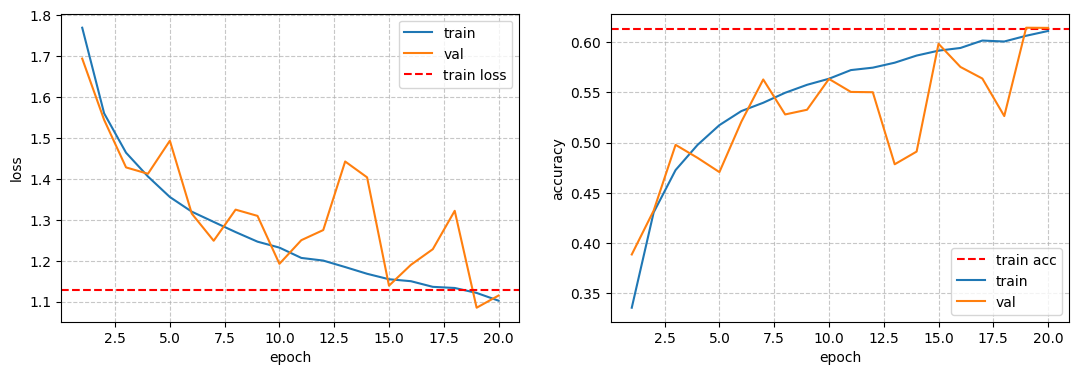

In [18]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log, test_loss_log, test_acc_log)

In [23]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.01)
start = time.time()
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
end = time.time()
print(f"duration: {end-start}")

Epoch 19
 train loss: 1.0947754056187826, train acc: 0.612610995115702
 val loss: 1.0864704238607528, val acc: 0.6138741135597229

duration: 322.51443552970886


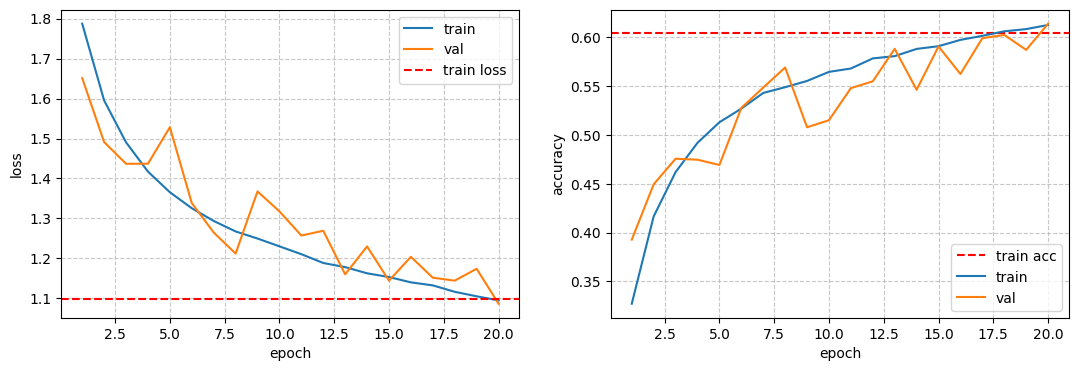

In [24]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log, test_loss_log, test_acc_log)

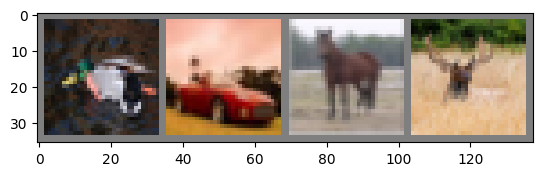

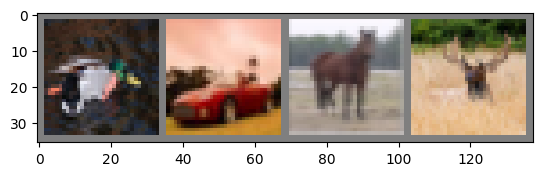

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

In [13]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 19
 train loss: 1.07963679085266, train acc: 0.6210580438756855
 val loss: 1.0673318010695436, val acc: 0.6241356382978723



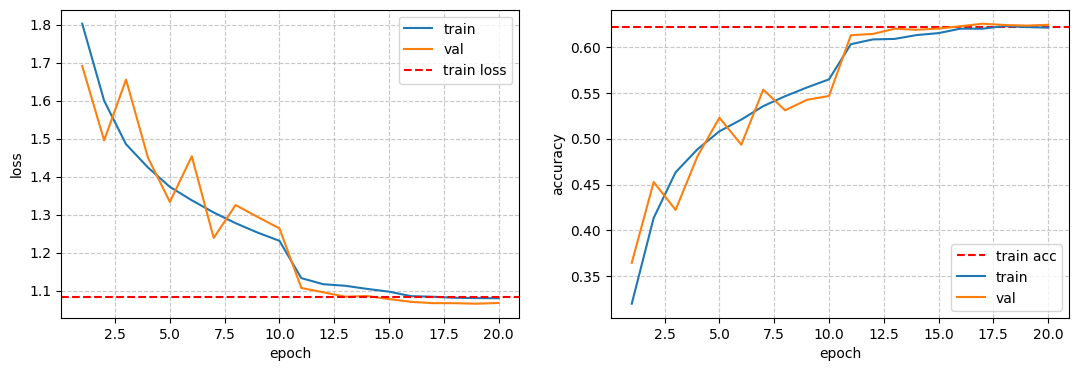

In [14]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log, test_loss_log, test_acc_log)

Применив аугментацию в виде случайного вращения относительно горизонатально оси с применением ступенчатого схемы понижения скорости обучения, можно сказать, что метрика accuracy и функция потерь не сильно изменилась по сравнению с тем, что было без трансформации изображения.

In [15]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness = (0.75,1.25),
                                contrast = (0.75,1.25),
                                saturation = (0.75, 1.25),
                                hue = (-0.1, 0.1)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 19
 train loss: 1.1496904545771793, train acc: 0.599622127233955
 val loss: 1.1297709718663642, val acc: 0.6044547872340426



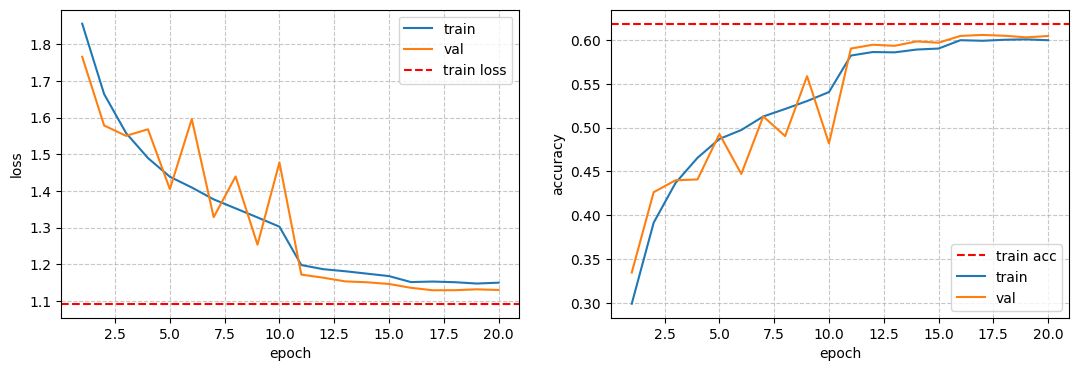

In [16]:
test_loss_log, test_acc_log = test(net, test_loader)
plot_losses(tr_loss_log, val_loss_log, tr_acc_log, val_acc_log, test_loss_log, test_acc_log)

Добавив транфсормацию изображения в виде изменения ярокости brightness = (0.75, 1.25), констранста contrast = (0.75, 1.25), насыщенности saturation = (0.75, 1.25), оттенка hue = (-0.1, 0.1).
Время выполняения кода увеличилсоь с 4 минут до 14, вместе с малым уменьшением результата с 0.63 метрики accuracy на ~0.60 и функции потерь 1.1 до 1.15